In [28]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt
import multiprocessing

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from IPython.display import clear_output, display
import subprocess
import glob
from pathlib import Path
import os
cwd = os.getcwd()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 425e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

18.389524275269295 arcsec
10.982853643600734


<Quantity 1.6743849 arcsec>

In [2]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [18]:
npsf = 50
cam.set_roi(575, 900, npsf, client0)

In [19]:
cam.set_exptime(0.0001, client0)

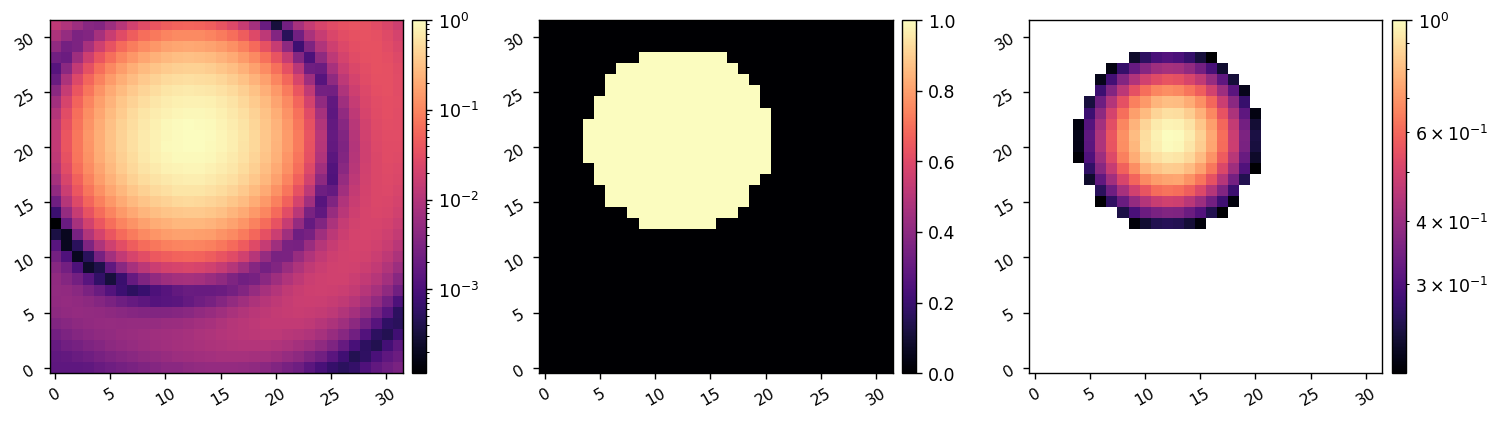

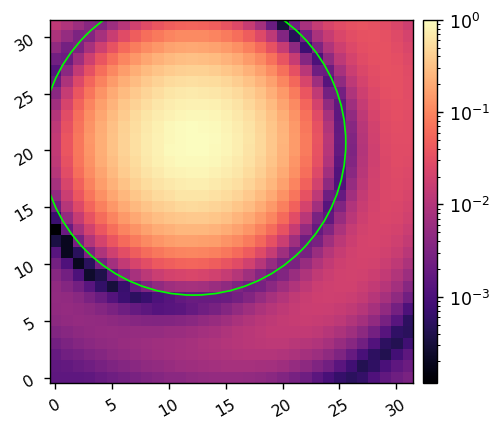

In [5]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


# Setup FSM Interface

In [6]:
fsm_bias_channel = ImageStream('dm00disp00')

In [7]:
fsm_bias_channel.write(v_bias)

In [24]:
fsm_bias_channel.write(zero)

# Setup and record the modulation

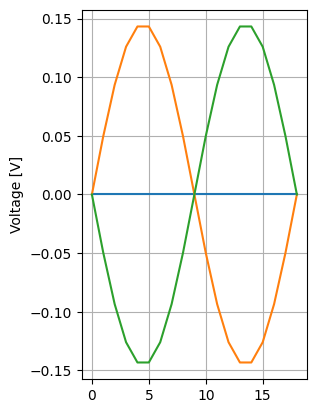

Saved data to:  /opt/MagAOX/calib/dm/fsm/fsm_cube.fits


In [13]:
# Define a sine wave
samps_per_wave = 19
amp = 1*u.arcsec

volt_commands = np.zeros((samps_per_wave, 3, 1))
wave = amp * np.sin(2*np.pi * np.arange(samps_per_wave)/(samps_per_wave-1))
for i in range(samps_per_wave):
    # volt_commands[i] = fsm_utils.get_fsm_volts(tip=wave[i], tilt=0*u.arcsec, dZ=0*u.um)
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=wave[i], dZ=0*u.um)

plt.subplot(122)
# plt.plot(wave)
plt.plot(volt_commands[:,0])
plt.plot(volt_commands[:,1])
plt.plot(volt_commands[:,2])
plt.ylabel('Voltage [V]')
plt.grid()
plt.show()

utils.save_fits('/opt/MagAOX/calib/dm/fsm/fsm_cube.fits', volt_commands[:-1])


In [19]:
t_total = 2
freq = 18

fsm_utils.set_fsm_mod_amp(5, client0)
fsm_utils.set_fsm_mod_rate(2*freq, client0)


In [20]:
fsm_utils.start_fsm_mod(client0)

In [21]:
fsm_utils.stop_fsm_mod(client0)

# Run the experiment.
### Define and make experiment directory if required

In [37]:
# Setup the directories to which the FSM and campupil data will be stored.

exp_dir = 'sin-mod'
exp_path = Path(f'{cwd}/data/{exp_dir}')

subprocess.run(['mkdir',str(exp_path)])

CompletedProcess(args=['mkdir', '/home/uasal/Projects/fsm-exps/data/sin-mod'], returncode=0)

In [38]:
reload(fsm_utils)

t_total = 2

fsm_utils.start_fsm_mod(client0, delay=0.5)
fsm_utils.toggle_telem_campupil(1, client0)
fsm_utils.toggle_telem_fsm(1, client0)

time.sleep(t_total)

fsm_utils.toggle_telem_campupil(0, client0)
fsm_utils.toggle_telem_fsm(0, client0)
fsm_utils.stop_fsm_mod(client0)



# Extract and analyze data

In [39]:
# Decompress the .xrif files from the telem_* apps into the desired data directories

exp_dir = 'sin-mod'
exp_path = f'{cwd}/data/{exp_dir}'

subprocess.run(['xrif2fits','-d','/opt/MagAOX/telem/campupil/','-D',exp_path])
clear_output()
subprocess.run(['xrif2fits','-d','/opt/MagAOX/telem/fsm/','-D',exp_path])
clear_output()

In [30]:
subprocess.run(['rm','/opt/MagAOX/telem/campupil/*.xrif'])
subprocess.run(['rm','/opt/MagAOX/telem/fsm/*.xrif'])

rm: cannot remove '/opt/MagAOX/telem/campupil/*.xrif': No such file or directory
rm: cannot remove '/opt/MagAOX/telem/fsm/*.xrif': No such file or directory


CompletedProcess(args=['rm', '/opt/MagAOX/telem/fsm/*.xrif'], returncode=1)

In [42]:
exp_dir = 'sin-mod'

exp_path = Path(f'{cwd}/data/{exp_dir}')  # Replace with the actual directory path

cam_data_fnames = sorted(glob.glob(str(exp_path/'campupil*20250129*.fits')))
fsm_data_fnames = sorted(glob.glob(str(exp_path/'dm00disp00*20250128*.fits')))
cam_data_fnames

['/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445382838457.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445383190442.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445383589728.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445383987916.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445384383817.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445384785152.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445385184562.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445385579711.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445385980449.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445386376490.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000445386774101.fits',
 '/home/uasal/Projects/fsm-exps/data/sin-mod/campupil_20250129000

In [43]:
import astropy.io.fits as fits

cam_start_time = float(cam_data_fnames[0].split("_")[1][12:-5])/1e9
print(cam_start_time)

frames = []
cam_times = []
for fname in cam_data_fnames:
    frames.append(fits.getdata(fname))
    cam_times.append(float(fname.split("_")[1][12:-5])/1e9)
frames = np.array(frames) 
cam_times = np.array(cam_times)
cam_times = cam_times - cam_times[0]

45.382838457


In [45]:
fsm_start_time = float(fsm_data_fnames[0].split("_")[1][12:-5])/1e9
print(cam_start_time)

fsm_commands = []
fsm_times = []
for fname in fsm_data_fnames:
    fsm_commands.append(fits.getdata(fname))
    fsm_times.append(float(fname.split("_")[1][12:-5])/1e9)
fsm_commands = np.array(fsm_commands) 
fsm_times = np.array(fsm_times)
fsm_times = fsm_times - cam_times[0]

45.382838457


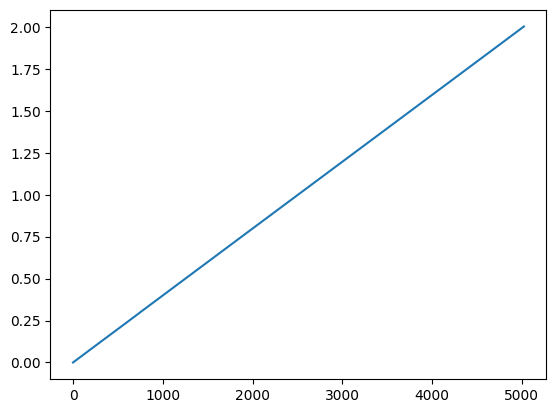

In [47]:
plt.plot(cam_times)

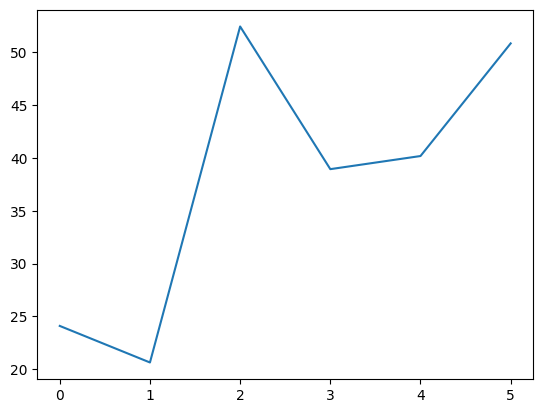

In [49]:
plt.plot(fsm_times)

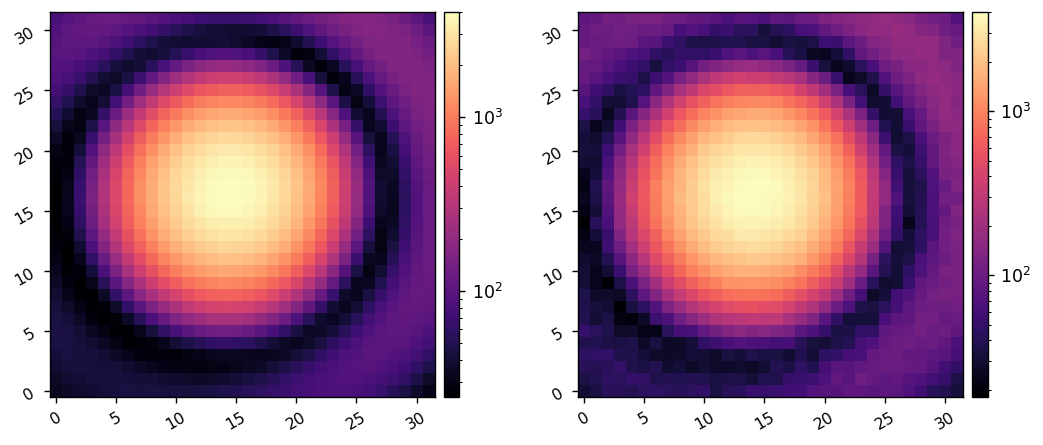

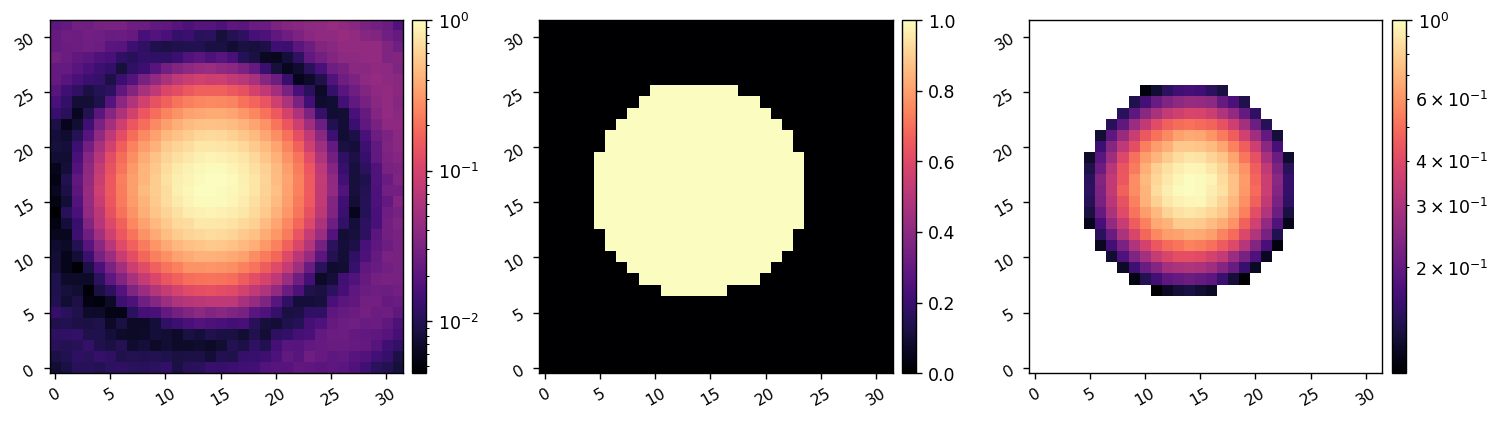

350.0 mas


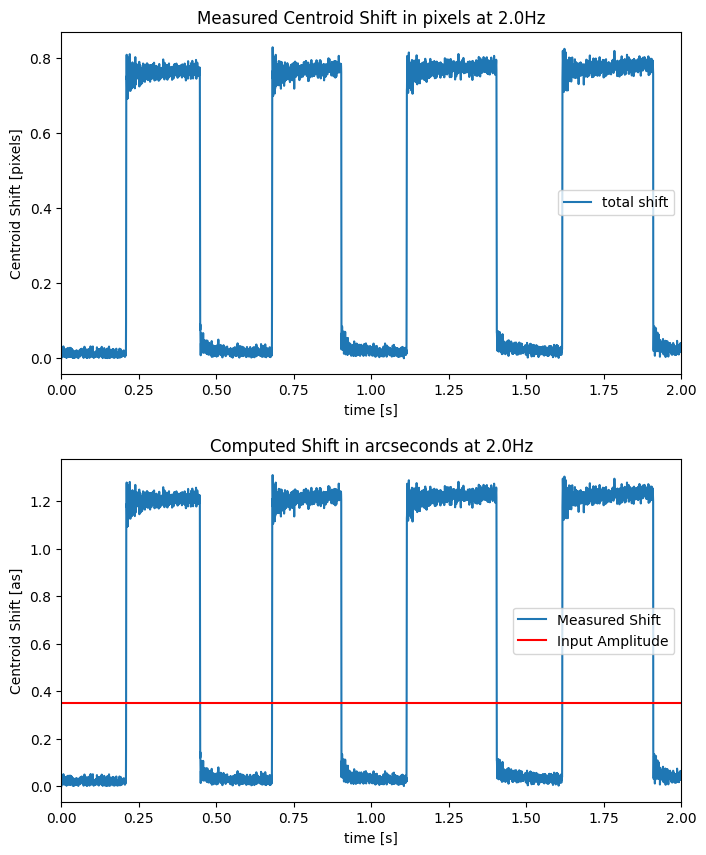

In [38]:
cthresh = 0.2

N = len(cam_data_fnames)
mean_frame = np.mean(frames, axis=0)
imshow2(mean_frame, frames[0], lognorm=True)

shift_pix = []
cen_0 = utils.centroid(frames[0].astype(float), thresh=cthresh, plot=True)
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
shift_pix = np.array(shift_pix)

shift_pix[:,0] = shift_pix[:,0] - shift_pix[0,0]
shift_pix[:,1] = shift_pix[:,1] - shift_pix[0,1]

total_shift = np.sqrt( np.sum( np.square(shift_pix), axis=1) )

shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
shift_as = np.sqrt( np.sum( np.square(shift_as), axis=1) )

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(cam_times, shift_pix[:,0], label='x-coordinate')
plt.plot(cam_times, shift_pix[:,1], label='y-coordinate')
plt.plot(cam_times, total_shift, label='total shift')
plt.ylabel('Centroid Shift [pixels]')
plt.xlabel('time [s]')
plt.xlim([0,cam_times.max()])
plt.legend()

plt.subplot(212)
plt.plot(fsm_times, , label='Measured Shift')
plt.ylabel('Centroid Shift [as]')
plt.xlabel('time [s]')
plt.xlim([0,times.max()])
# plt.xlim([0, 1])
plt.legend()

4.0


(0.0, 2.0)

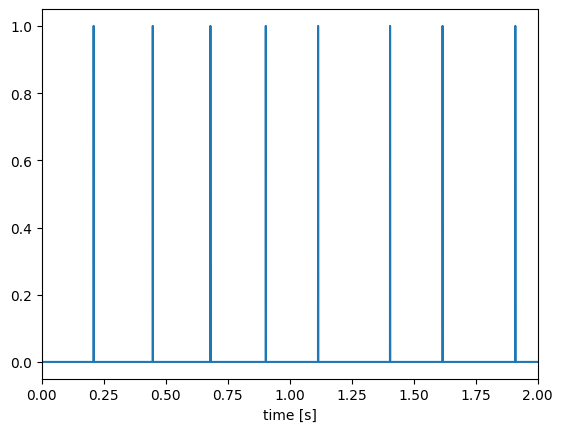

In [40]:
shift_thresh = 0.5*u.arcsec
# shift_thresh = 0.1*u.arcsec

shift_ud = shift_as>shift_thresh
steps = np.abs(shift_ud[1:].astype(float) - shift_ud[:-1].astype(float))
step_count = np.sum(steps)
print(step_count/tmax)

# plt.plot(times, shift_ud,)
# plt.xlabel('time [s]')
# plt.xlim([0,times.max()])
# plt.xlim([0, 1])

plt.plot(times[1:], steps,)
plt.xlabel('time [s]')
plt.xlim([0,tmax])
# plt.xlim([0, 1])
